# DDQN Test Notebook (Project-Integrated)

- Use project modules directly (`env.py`, `model.py`, `rollout.py`, `viz_matplotlib.py`, `viz_route_map.py`).
- Support testing one `.jsonl` or a folder of `.jsonl` scenarios.
- `case_mode="full_stream"`: one jsonl file as one multi-dispatch scenario.
- `case_mode="each_line"`: each line in a jsonl file is one single-dispatch testcase.


In [1]:
%matplotlib inline
import os
import json
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from collections import defaultdict
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from data_io import load_records
from env import TaskSchedulingEnv
from features import flatten_jobs
from model import QNetwork
from rollout import run_greedy_episode
from viz_matplotlib import draw_amr_schedule, draw_dispatch_queue, draw_input_queue
from viz_route_map import show_route_map_replay, _robot_snapshot_at_time
from viz_plotly import show_interactive_schedule_plotly


def _normalize_records(records: List[dict]) -> List[dict]:
    out: List[dict] = []
    for rec in records:
        if not isinstance(rec, dict) or "jobs" not in rec:
            raise ValueError("Each record must be a dict with key 'jobs'.")
        jobs = rec.get("jobs", [])
        if not isinstance(jobs, list):
            raise ValueError("record['jobs'] must be a list")
        out.append({
            "dispatch_time": float(rec.get("dispatch_time", 0.0)),
            "jobs": jobs,
        })
    return out


def _load_policy(model_path: str, device: torch.device, default_input_dim: int) -> nn.Module:
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model not found: {model_path}")

    ckpt = torch.load(model_path, map_location=device)
    if isinstance(ckpt, dict) and "model_state" in ckpt:
        model_state = ckpt["model_state"]
        input_dim = int(ckpt.get("input_dim", default_input_dim))
    else:
        model_state = ckpt
        input_dim = int(default_input_dim)

    model = QNetwork(input_dim).to(device)
    try:
        model.load_state_dict(model_state)
    except Exception as e:
        raise RuntimeError(
            "Checkpoint architecture mismatch with current model.py. "
            "Please use a checkpoint trained by current project code."
        ) from e
    model.eval()
    return model


def _prepare_runtime(model_path: str, allow_proactive_replenish: bool = True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = TaskSchedulingEnv()
    env.allow_proactive_replenish = allow_proactive_replenish
    state_dim = len(env.reset([]))
    action_dim = 4
    input_dim = state_dim + action_dim
    policy_net = _load_policy(model_path, device, input_dim)
    return device, env, policy_net


def _case_metrics(scenario: Union[dict, List[dict]], makespan: float) -> Dict[str, float]:
    jobs = flatten_jobs(scenario)
    job_n = len(jobs)
    total_proc = float(sum(float(j.get("proc_time", 0.0)) for j in jobs))
    mk_per_job = float(makespan / max(1, job_n))
    mk_per_proc = float(makespan / max(1e-6, total_proc))
    return {
        "job_count": float(job_n),
        "total_proc": total_proc,
        "mk_per_job": mk_per_job,
        "mk_per_proc": mk_per_proc,
    }


def _plot_case(
    env: TaskSchedulingEnv,
    scenario: Union[dict, List[dict]],
    makespan: float,
    title: str,
    save_path: Optional[str] = None,
    show_figure: bool = True,
) -> None:
    fig, axes = plt.subplots(3, 1, figsize=(14, 8))
    fig.subplots_adjust(hspace=0.45, top=0.9)
    fig.suptitle(title)

    draw_dispatch_queue(axes[0], env.trace)
    draw_amr_schedule(axes[1], env.trace, makespan, inventories=env.robot_inventory)
    draw_input_queue(axes[2], scenario)

    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=180)
    if show_figure:
        plt.show()
    else:
        plt.close(fig)


def _export_amr_route_jsonl(
    env: TaskSchedulingEnv,
    trace: List[dict],
    out_path: str,
    time_step: float = 1.0,
    include_endpoint: bool = True,
) -> int:
    step = max(1e-6, float(time_step))
    out_file = Path(out_path)
    out_file.parent.mkdir(parents=True, exist_ok=True)

    _snap0, max_t = _robot_snapshot_at_time(env, trace, 0.0)
    max_t = max(0.0, float(max_t))
    ts = list(np.arange(0.0, max_t + 1e-9, step))
    if include_endpoint and (not ts or max_t - ts[-1] > 1e-9):
        ts.append(max_t)

    with out_file.open("w", encoding="utf-8") as f:
        for t in ts:
            snaps, _ = _robot_snapshot_at_time(env, trace, float(t))
            amrs: List[dict] = []
            for s in snaps:
                inv = s.get("inventory_net", s.get("inv", {}))
                inv_net = {
                    "A": int(inv.get("A", 0)),
                    "B": int(inv.get("B", 0)),
                    "C": int(inv.get("C", 0)),
                }
                route = s.get("route", [])
                amrs.append(
                    {
                        "rid": int(s.get("rid", -1)),
                        "name": f"AMR{int(s.get('rid', -1)) + 1}",
                        "x": float(s.get("pos", (0.0, 0.0))[0]),
                        "y": float(s.get("pos", (0.0, 0.0))[1]),
                        "status": str(s.get("status", "")),
                        "mode": str(s.get("mode", "")),
                        "jid": None if s.get("jid") is None else int(s.get("jid")),
                        "dst": s.get("dst"),
                        "inventory": dict(inv_net),
                        "inventory_net": dict(inv_net),
                        "inventory_semantics": s.get("inventory_semantics", {}),
                        "route": [[float(p[0]), float(p[1])] for p in route],
                        "proc_elapsed": float(s.get("proc_elapsed", 0.0)),
                        "proc_total": float(s.get("proc_total", 0.0)),
                        "proc_remaining": float(s.get("proc_remaining", 0.0)),
                    }
                )

            rec = {
                "t": float(round(float(t), 6)),
                "amrs": amrs,
            }
            f.write(json.dumps(rec, ensure_ascii=False) + "\n")

    return len(ts)


def _summary_line(results: List[Dict[str, object]], title: str = "SUMMARY") -> str:
    if not results:
        return f"{title}|cases=0"

    mk = np.asarray([float(r["makespan"]) for r in results], dtype=np.float64)
    mk_per_job = np.asarray([float(r["mk_per_job"]) for r in results], dtype=np.float64)
    mk_per_proc = np.asarray([float(r["mk_per_proc"]) for r in results], dtype=np.float64)
    job_n = np.asarray([float(r["job_count"]) for r in results], dtype=np.float64)

    return (
        f"{title}|cases={len(results)}|total_jobs={int(job_n.sum())}|"
        f"mk_avg={mk.mean():.3f}|mk_std={mk.std(ddof=0):.3f}|"
        f"mk_min={mk.min():.3f}|mk_max={mk.max():.3f}|"
        f"mk_job_avg={mk_per_job.mean():.3f}|mk_proc_avg={mk_per_proc.mean():.3f}"
    )


def _print_summary(results: List[Dict[str, object]], title: str = "SUMMARY") -> str:
    line = _summary_line(results, title=title)
    print(line)
    return line


def _case_stat_lines(results: List[Dict[str, object]]) -> List[str]:
    lines: List[str] = []
    ordered = sorted(results, key=lambda r: (str(r.get("file", "")), int(r.get("case_id", -1))))
    for r in ordered:
        fname = str(r.get("file", ""))
        mode = str(r.get("mode", ""))
        case_id = int(r.get("case_id", -1))
        jobs = int(float(r.get("job_count", 0.0)))
        mk = float(r.get("makespan", 0.0))
        mk_job = float(r.get("mk_per_job", 0.0))
        mk_proc = float(r.get("mk_per_proc", 0.0))

        if mode == "full_stream":
            prefix = "STREAM"
        else:
            prefix = f"CASE {case_id:03d}"

        lines.append(
            f"[{fname}] {prefix} jobs={jobs} mk={mk:.3f} "
            f"mk/job={mk_job:.3f} mk/proc={mk_proc:.3f}"
        )

        if "route_jsonl_path" in r:
            route_path = str(r.get("route_jsonl_path", ""))
            route_lines = int(r.get("route_jsonl_lines", 0))
            lines.append(
                f"[{fname}] CASE {case_id:03d} route_jsonl={route_path} lines={route_lines}"
            )

    return lines


def _per_file_summary_lines(results: List[Dict[str, object]]) -> List[str]:
    grouped: Dict[str, List[Dict[str, object]]] = defaultdict(list)
    for r in results:
        grouped[str(r.get("file", ""))].append(r)

    lines: List[str] = []
    for fname in sorted(grouped.keys()):
        rs = grouped[fname]
        mk = np.asarray([float(x.get("makespan", 0.0)) for x in rs], dtype=np.float64)
        lines.append(
            f"PER_FILE|file={fname}|cases={len(rs)}|"
            f"mk_avg={mk.mean():.3f}|mk_min={mk.min():.3f}|mk_max={mk.max():.3f}"
        )
    return lines


def _write_stats_txt(path: str, lines: List[str], append: bool = False) -> None:
    out = Path(path)
    out.parent.mkdir(parents=True, exist_ok=True)
    mode = "a" if append else "w"
    with out.open(mode, encoding="utf-8") as f:
        for line in lines:
            f.write(str(line) + "\n")


def run_single_jsonl(
    jsonl_path: str,
    model_path: str = "ddqn_policy.pt",
    case_mode: str = "full_stream",  # "full_stream" | "each_line"
    max_cases: Optional[int] = None,
    plot: bool = False,
    save_plots: bool = False,
    plot_dir: str = "test_plots",
    show_route_map: bool = False,
    show_plotly: bool = False,
    plotly_html_dir: str = "test_plots_html",
    plotly_window: float = 80.0,
    plotly_step: float = 5.0,
    save_route_jsonl: bool = False,
    route_jsonl_dir: str = "test_route_logs",
    route_time_step: float = 1.0,
    allow_proactive_replenish: bool = True,
    _runtime=None,
) -> List[Dict[str, object]]:
    if case_mode not in {"full_stream", "each_line"}:
        raise ValueError("case_mode must be 'full_stream' or 'each_line'")

    raw_records = load_records(jsonl_path)
    records = _normalize_records(raw_records)
    if not records:
        raise RuntimeError(f"No records found in {jsonl_path}")

    if _runtime is None:
        device, env, policy_net = _prepare_runtime(model_path, allow_proactive_replenish)
        print("device =", device)
    else:
        device, env, policy_net = _runtime

    file_name = Path(jsonl_path).name
    if case_mode == "full_stream":
        scenarios: List[Tuple[int, Union[dict, List[dict]]]] = [(0, records)]
    else:
        total = len(records) if max_cases is None else min(len(records), max_cases)
        scenarios = [(i, records[i]) for i in range(total)]

    results: List[Dict[str, object]] = []
    case_logs: List[str] = []
    for idx, scenario in scenarios:
        mk = float(run_greedy_episode(env, policy_net, scenario, device))
        m = _case_metrics(scenario, mk)

        row: Dict[str, object] = {
            "file": file_name,
            "case_id": int(idx),
            "mode": case_mode,
            "makespan": mk,
            **m,
        }
        results.append(row)

        if case_mode == "full_stream":
            case_logs.append(
                f"[{file_name}] STREAM lines={len(records)} jobs={int(m['job_count'])} "
                f"mk={mk:.3f} mk/job={m['mk_per_job']:.3f} mk/proc={m['mk_per_proc']:.3f}"
            )
        else:
            case_logs.append(
                f"[{file_name}] CASE {idx:03d} jobs={int(m['job_count'])} "
                f"mk={mk:.3f} mk/job={m['mk_per_job']:.3f} mk/proc={m['mk_per_proc']:.3f}"
            )

        case_title = (
            f"{file_name} | mode={case_mode} | case={idx:03d} | "
            f"jobs={int(m['job_count'])} | mk={mk:.2f}s"
        )

        if save_route_jsonl:
            route_dir = Path(route_jsonl_dir)
            route_dir.mkdir(parents=True, exist_ok=True)
            route_name = f"{Path(file_name).stem}_case_{idx:03d}_amr_path.jsonl"
            route_path = str(route_dir / route_name)
            line_count = _export_amr_route_jsonl(
                env,
                env.trace,
                route_path,
                time_step=route_time_step,
                include_endpoint=True,
            )
            row["route_jsonl_path"] = route_path
            row["route_jsonl_lines"] = int(line_count)
            case_logs.append(f"[{file_name}] CASE {idx:03d} route_jsonl={route_path} lines={line_count}")

        if plot or save_plots:
            out_path = None
            if save_plots:
                out_name = f"{Path(file_name).stem}_case_{idx:03d}.png"
                out_path = os.path.join(plot_dir, out_name)
            _plot_case(env, scenario, mk, title=case_title, save_path=out_path, show_figure=plot)

        if show_plotly:
            html_dir = Path(plotly_html_dir)
            html_dir.mkdir(parents=True, exist_ok=True)
            html_name = f"{Path(file_name).stem}_case_{idx:03d}.html"
            html_path = str(html_dir / html_name)
            show_interactive_schedule_plotly(
                trace=env.trace,
                input_source=scenario,
                makespan=mk,
                inventories=env.robot_inventory,
                window=plotly_window,
                step=plotly_step,
                html_path=html_path,
                title_info=case_title,
            )

        if show_route_map:
            show_route_map_replay(env, env.trace, initial_t=0.0, play_step=0.5, play_interval_ms=120)

    for msg in case_logs:
        print(msg)

    return results


def run_test_case_folder(
    folder_path: str,
    model_path: str = "ddqn_policy.pt",
    case_mode: str = "full_stream",
    max_files: Optional[int] = None,
    max_cases_per_file: Optional[int] = None,
    plot: bool = False,
    save_plots: bool = False,
    plot_dir: str = "test_plots",
    show_route_map: bool = False,
    show_plotly: bool = False,
    plotly_html_dir: str = "test_plots_html",
    plotly_window: float = 80.0,
    plotly_step: float = 5.0,
    save_route_jsonl: bool = False,
    route_jsonl_dir: str = "test_route_logs",
    route_time_step: float = 1.0,
    allow_proactive_replenish: bool = True,
) -> List[Dict[str, object]]:
    folder = Path(folder_path)
    if not folder.exists() or not folder.is_dir():
        raise NotADirectoryError(f"Not a directory: {folder_path}")

    files = sorted(folder.glob("*.jsonl"))
    if not files:
        raise RuntimeError(f"No jsonl files found in {folder_path}")
    if max_files is not None:
        files = files[: max(0, int(max_files))]

    device, env, policy_net = _prepare_runtime(model_path, allow_proactive_replenish)
    print("device =", device)

    all_results: List[Dict[str, object]] = []
    for fp in files:
        file_results = run_single_jsonl(
            jsonl_path=str(fp),
            model_path=model_path,
            case_mode=case_mode,
            max_cases=max_cases_per_file,
            plot=plot,
            save_plots=save_plots,
            plot_dir=plot_dir,
            show_route_map=show_route_map,
            show_plotly=show_plotly,
            plotly_html_dir=plotly_html_dir,
            plotly_window=plotly_window,
            plotly_step=plotly_step,
            save_route_jsonl=save_route_jsonl,
            route_jsonl_dir=route_jsonl_dir,
            route_time_step=route_time_step,
            allow_proactive_replenish=allow_proactive_replenish,
            _runtime=(device, env, policy_net),
        )
        all_results.extend(file_results)

    # per-file summary
    grouped: Dict[str, List[Dict[str, object]]] = defaultdict(list)
    for r in all_results:
        grouped[str(r["file"])].append(r)

    print("\n====== PER-FILE SUMMARY ======")
    for fname in sorted(grouped.keys()):
        rs = grouped[fname]
        mk = np.asarray([float(x["makespan"]) for x in rs], dtype=np.float64)
        print(f"{fname}: cases={len(rs)} avg_mk={mk.mean():.3f} min={mk.min():.3f} max={mk.max():.3f}")
    print("==============================")

    return all_results


def run_tests(
    target_path: str,
    model_path: str = "ddqn_policy.pt",
    case_mode: str = "full_stream",
    max_files: Optional[int] = None,
    max_cases_per_file: Optional[int] = None,
    plot: bool = False,
    save_plots: bool = False,
    plot_dir: str = "test_plots",
    show_route_map: bool = False,
    show_plotly: bool = False,
    plotly_html_dir: str = "test_plots_html",
    plotly_window: float = 80.0,
    plotly_step: float = 5.0,
    save_route_jsonl: bool = False,
    route_jsonl_dir: str = "test_route_logs",
    route_time_step: float = 1.0,
    save_stats_txt: bool = False,
    stats_txt_path: str = "test_output/test_stats.txt",
    stats_txt_append: bool = False,
    allow_proactive_replenish: bool = True,
) -> List[Dict[str, object]]:
    p = Path(target_path)
    if p.is_dir():
        results = run_test_case_folder(
            folder_path=str(p),
            model_path=model_path,
            case_mode=case_mode,
            max_files=max_files,
            max_cases_per_file=max_cases_per_file,
            plot=plot,
            save_plots=save_plots,
            plot_dir=plot_dir,
            show_route_map=show_route_map,
            show_plotly=show_plotly,
            plotly_html_dir=plotly_html_dir,
            plotly_window=plotly_window,
            plotly_step=plotly_step,
            save_route_jsonl=save_route_jsonl,
            route_jsonl_dir=route_jsonl_dir,
            route_time_step=route_time_step,
            allow_proactive_replenish=allow_proactive_replenish,
        )
        summary_line = _print_summary(results, title=f"FOLDER SUMMARY ({p.name})")
        if save_stats_txt:
            txt_lines: List[str] = []
            txt_lines.append(f"RUN|target={target_path}|mode={case_mode}|scope=folder")
            txt_lines.extend(_case_stat_lines(results))
            txt_lines.extend(_per_file_summary_lines(results))
            txt_lines.append(summary_line)
            _write_stats_txt(stats_txt_path, txt_lines, append=stats_txt_append)
            print(f"stats_txt={stats_txt_path} lines={len(txt_lines)}")
        return results

    if p.is_file():
        results = run_single_jsonl(
            jsonl_path=str(p),
            model_path=model_path,
            case_mode=case_mode,
            max_cases=max_cases_per_file,
            plot=plot,
            save_plots=save_plots,
            plot_dir=plot_dir,
            show_route_map=show_route_map,
            show_plotly=show_plotly,
            plotly_html_dir=plotly_html_dir,
            plotly_window=plotly_window,
            plotly_step=plotly_step,
            save_route_jsonl=save_route_jsonl,
            route_jsonl_dir=route_jsonl_dir,
            route_time_step=route_time_step,
            allow_proactive_replenish=allow_proactive_replenish,
        )
        summary_line = _print_summary(results, title=f"FILE SUMMARY ({p.name})")
        if save_stats_txt:
            txt_lines: List[str] = []
            txt_lines.append(f"RUN|target={target_path}|mode={case_mode}|scope=file")
            txt_lines.extend(_case_stat_lines(results))
            txt_lines.extend(_per_file_summary_lines(results))
            txt_lines.append(summary_line)
            _write_stats_txt(stats_txt_path, txt_lines, append=stats_txt_append)
            print(f"stats_txt={stats_txt_path} lines={len(txt_lines)}")
        return results

    raise FileNotFoundError(f"Path not found: {target_path}")


device = cuda


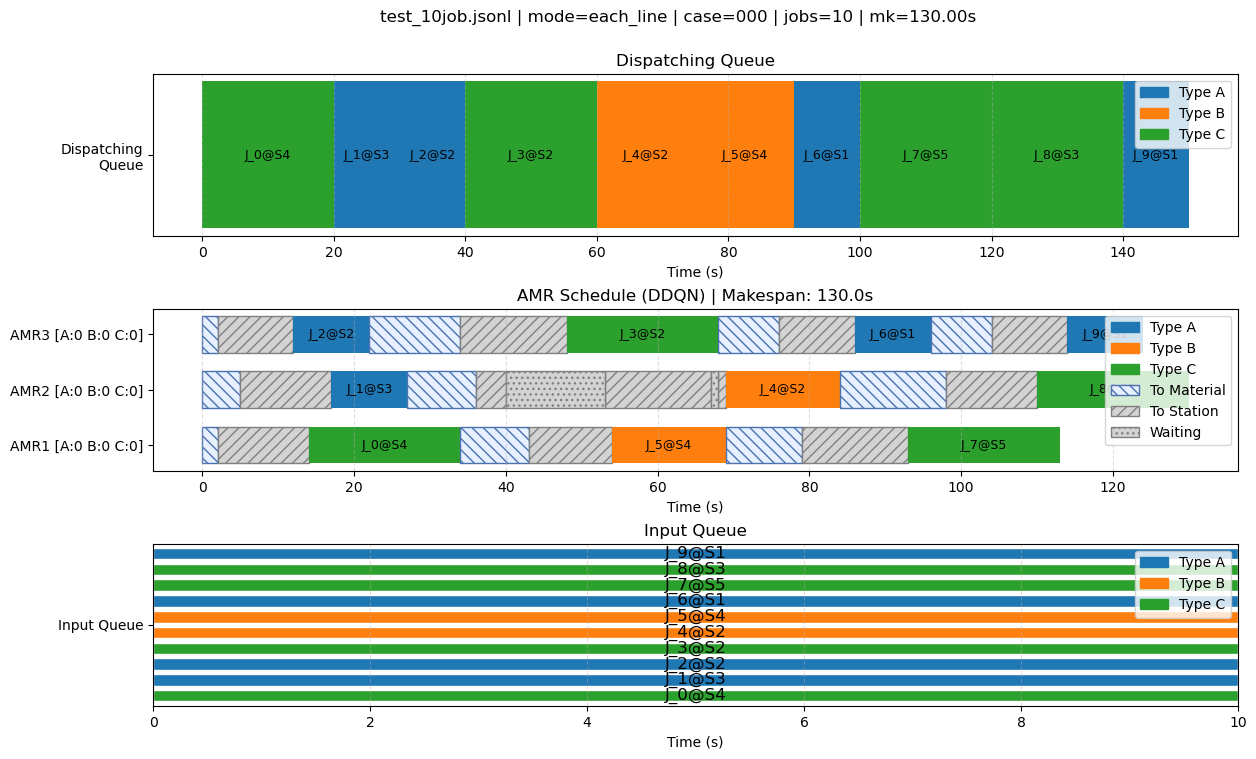

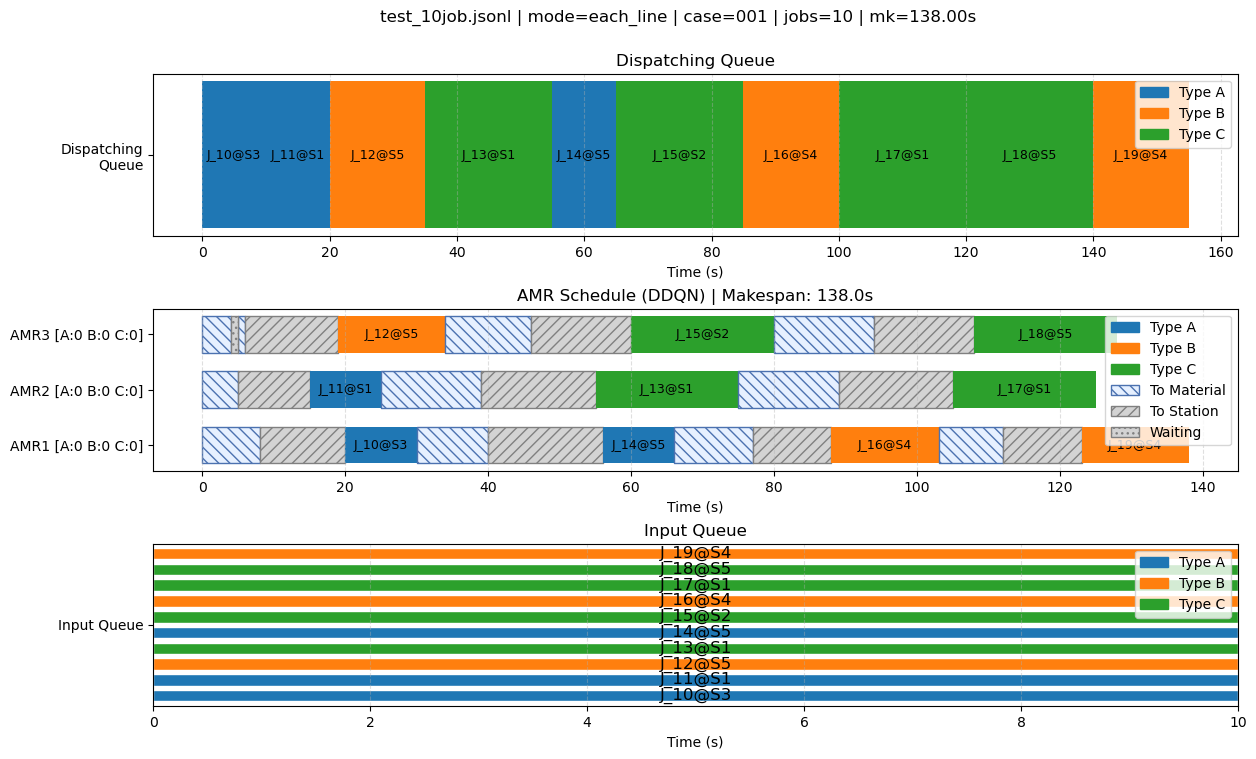

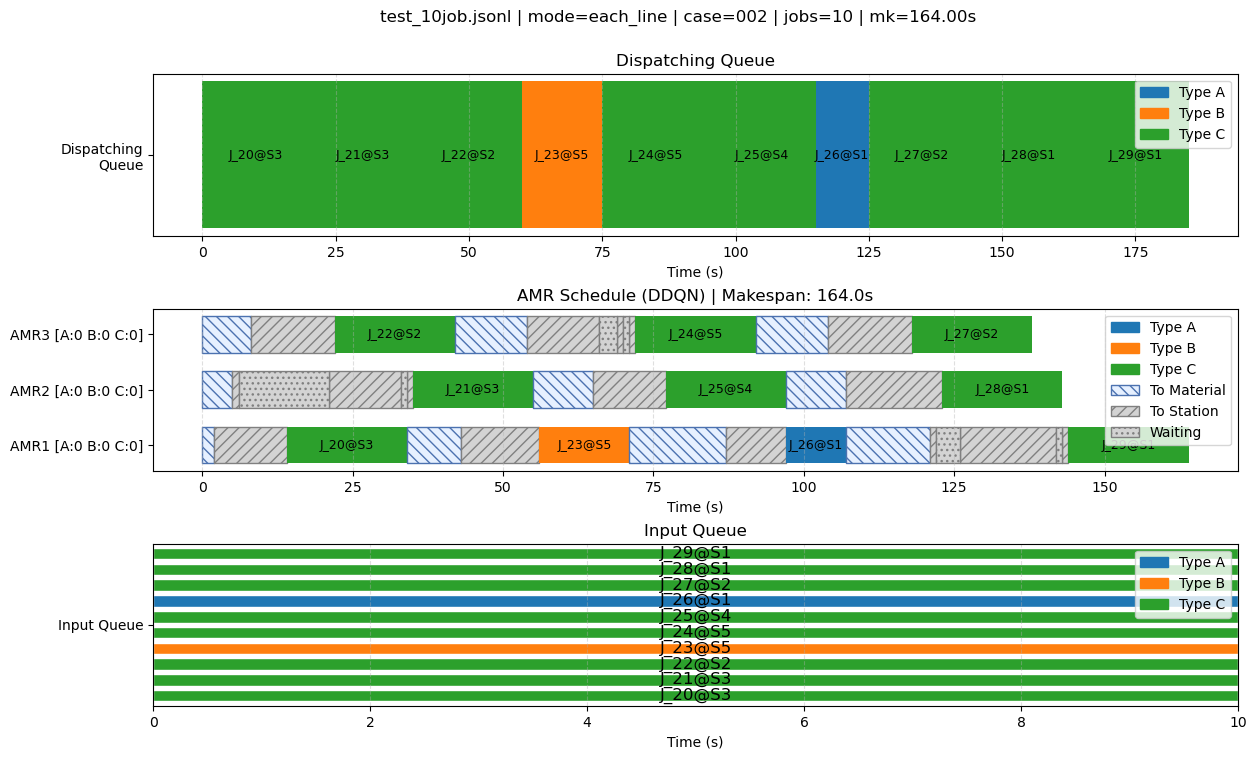

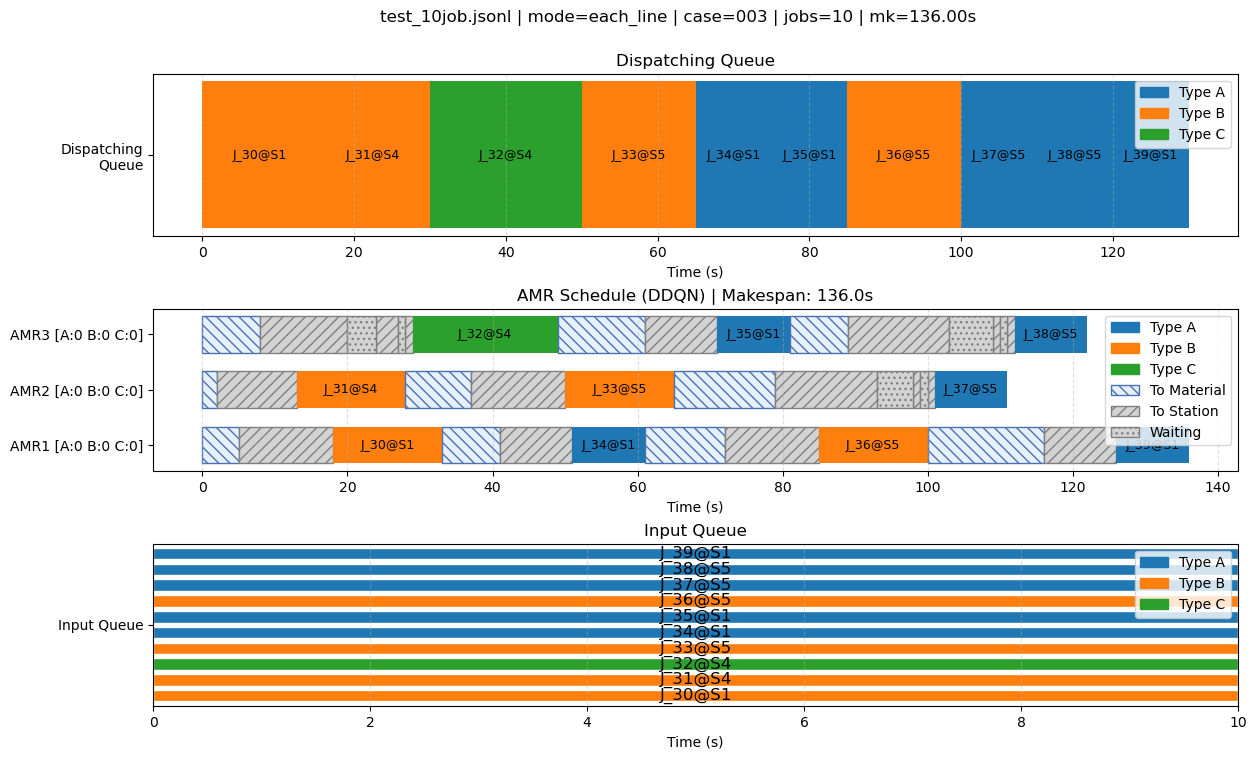

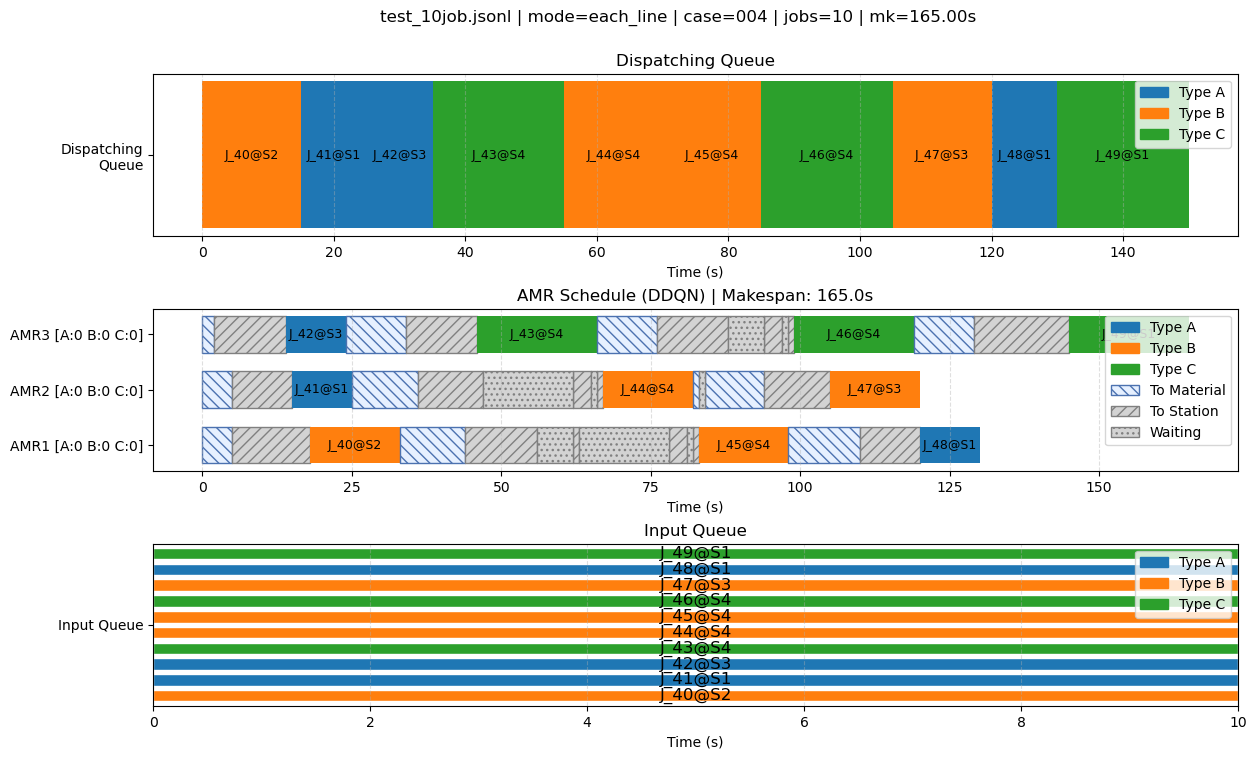

[test_10job.jsonl] CASE 000 jobs=10 mk=130.000 mk/job=13.000 mk/proc=0.867
[test_10job.jsonl] CASE 000 route_jsonl=test_route_logs\test_10job_case_000_amr_path.jsonl lines=131
[test_10job.jsonl] CASE 001 jobs=10 mk=138.000 mk/job=13.800 mk/proc=0.890
[test_10job.jsonl] CASE 001 route_jsonl=test_route_logs\test_10job_case_001_amr_path.jsonl lines=139
[test_10job.jsonl] CASE 002 jobs=10 mk=164.000 mk/job=16.400 mk/proc=0.886
[test_10job.jsonl] CASE 002 route_jsonl=test_route_logs\test_10job_case_002_amr_path.jsonl lines=165
[test_10job.jsonl] CASE 003 jobs=10 mk=136.000 mk/job=13.600 mk/proc=1.046
[test_10job.jsonl] CASE 003 route_jsonl=test_route_logs\test_10job_case_003_amr_path.jsonl lines=137
[test_10job.jsonl] CASE 004 jobs=10 mk=165.000 mk/job=16.500 mk/proc=1.100
[test_10job.jsonl] CASE 004 route_jsonl=test_route_logs\test_10job_case_004_amr_path.jsonl lines=166


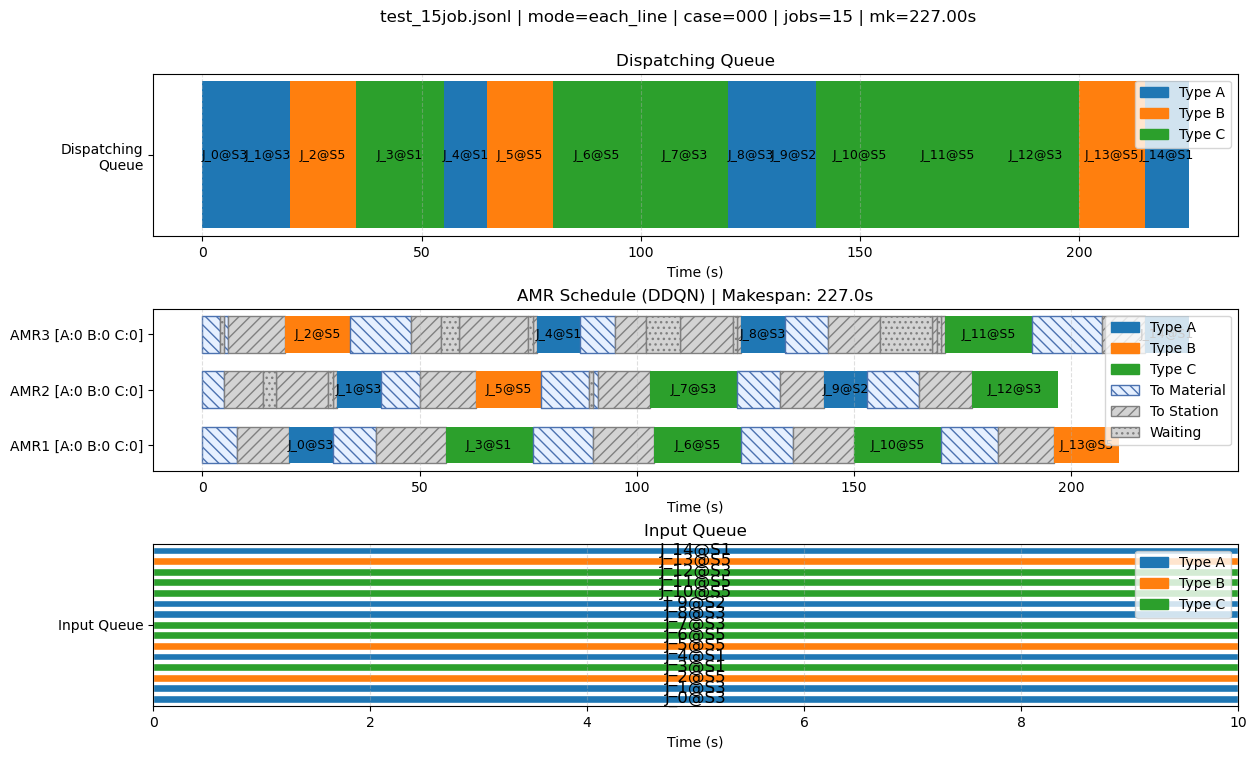

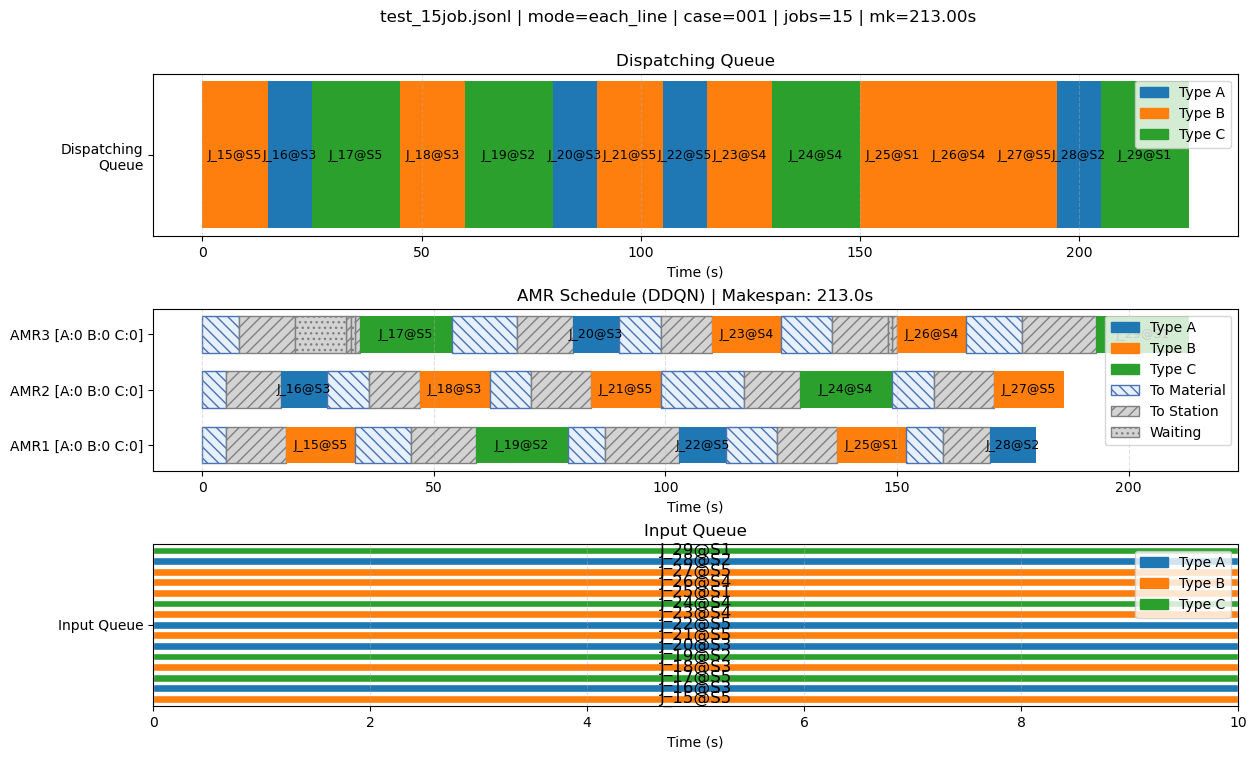

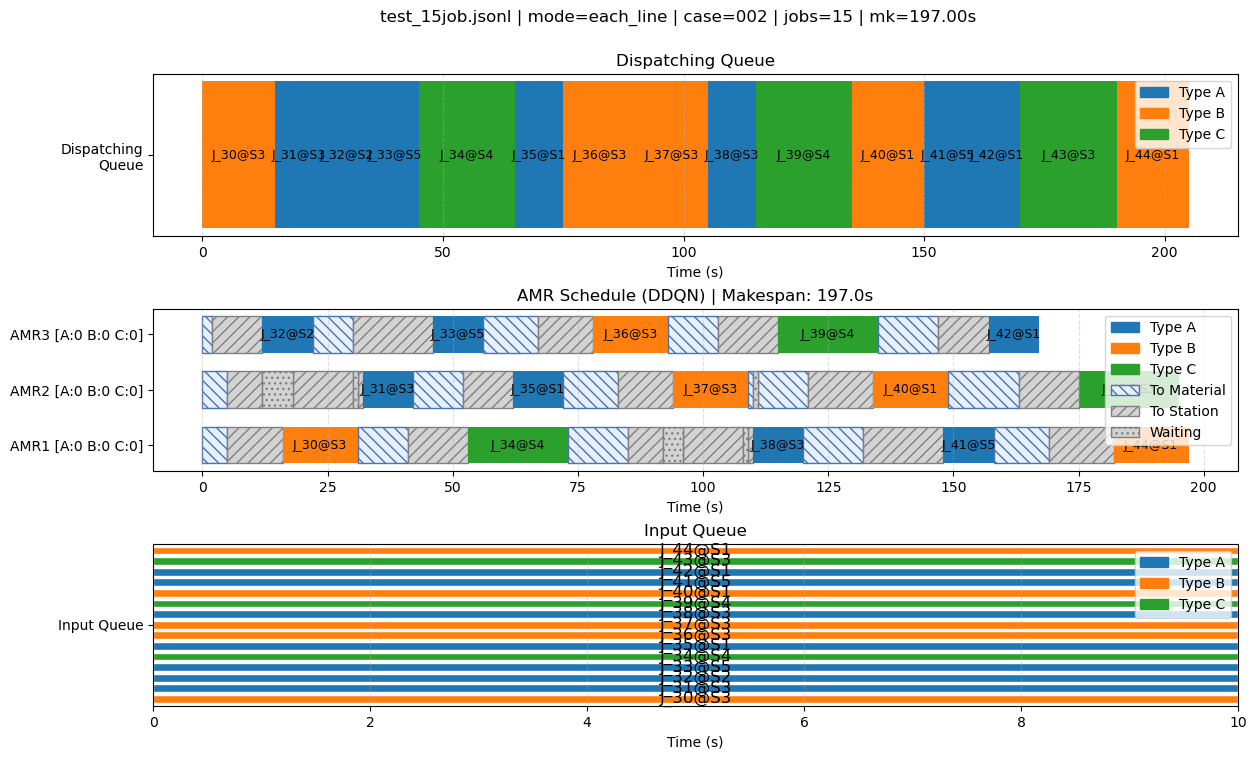

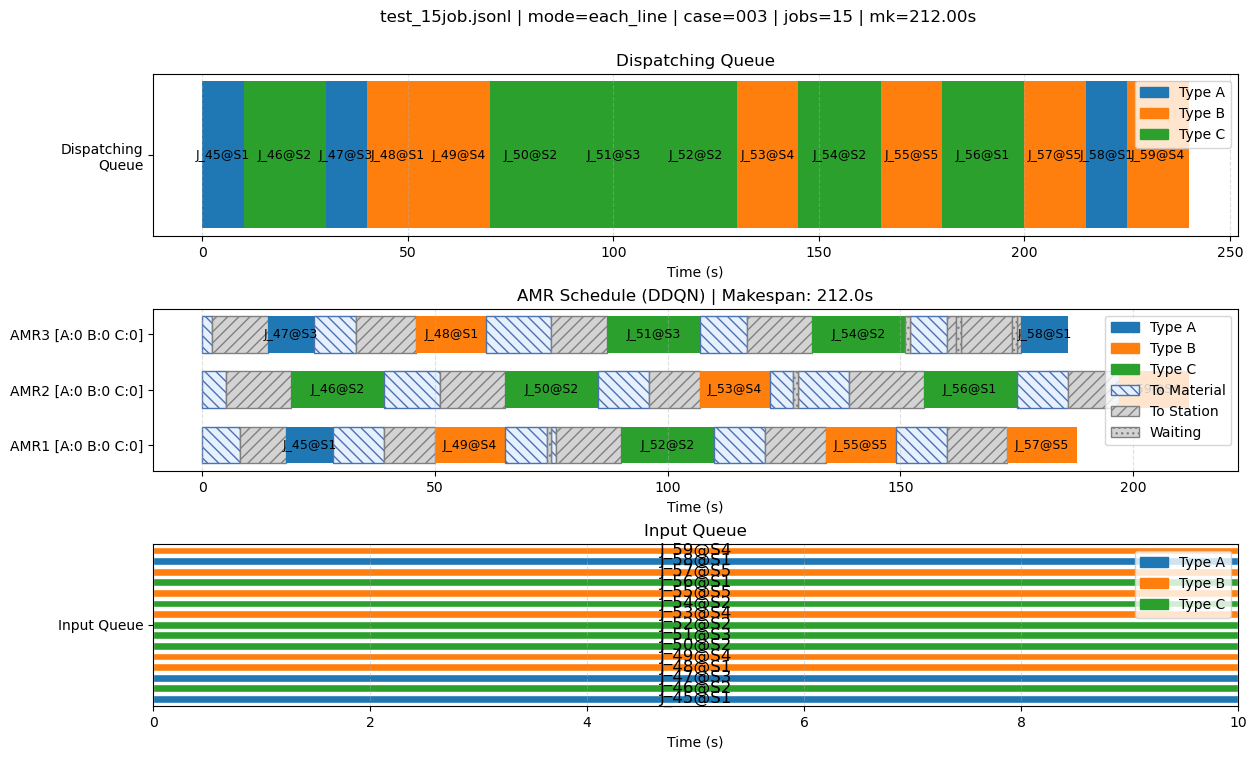

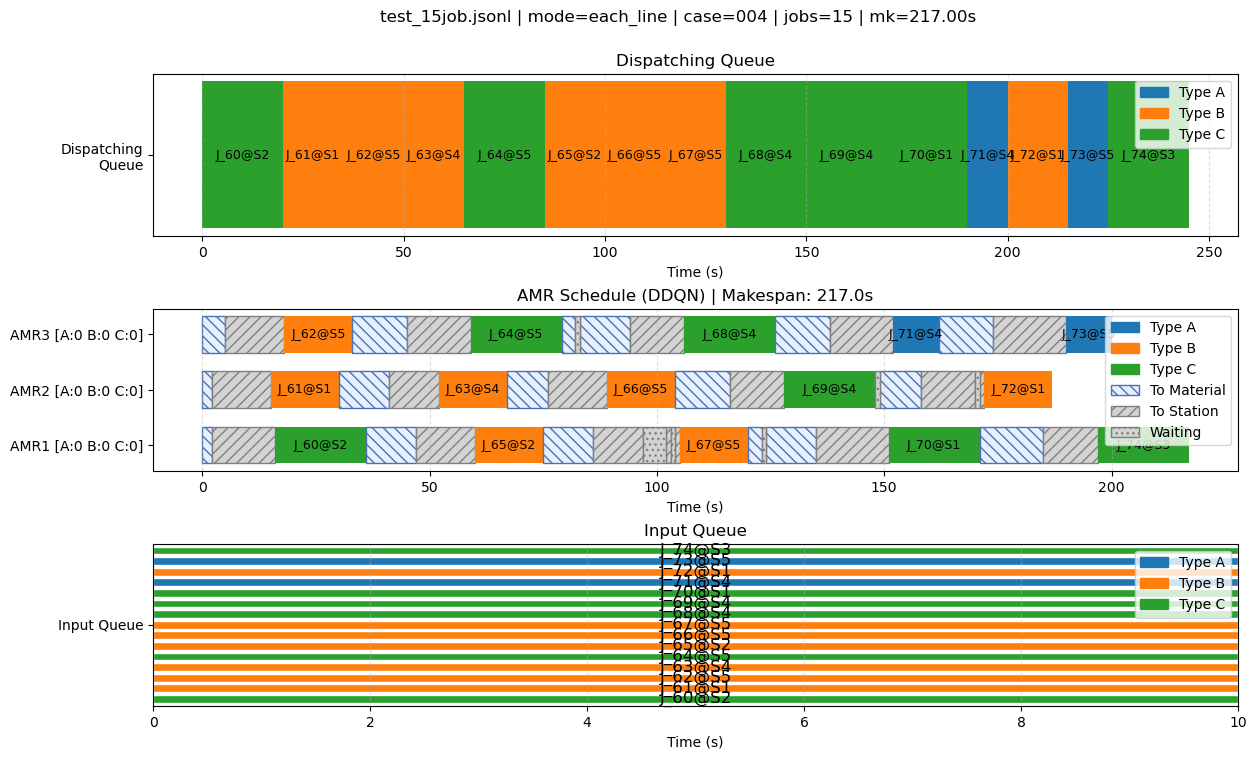

[test_15job.jsonl] CASE 000 jobs=15 mk=227.000 mk/job=15.133 mk/proc=1.009
[test_15job.jsonl] CASE 000 route_jsonl=test_route_logs\test_15job_case_000_amr_path.jsonl lines=228
[test_15job.jsonl] CASE 001 jobs=15 mk=213.000 mk/job=14.200 mk/proc=0.947
[test_15job.jsonl] CASE 001 route_jsonl=test_route_logs\test_15job_case_001_amr_path.jsonl lines=214
[test_15job.jsonl] CASE 002 jobs=15 mk=197.000 mk/job=13.133 mk/proc=0.961
[test_15job.jsonl] CASE 002 route_jsonl=test_route_logs\test_15job_case_002_amr_path.jsonl lines=198
[test_15job.jsonl] CASE 003 jobs=15 mk=212.000 mk/job=14.133 mk/proc=0.883
[test_15job.jsonl] CASE 003 route_jsonl=test_route_logs\test_15job_case_003_amr_path.jsonl lines=213
[test_15job.jsonl] CASE 004 jobs=15 mk=217.000 mk/job=14.467 mk/proc=0.886
[test_15job.jsonl] CASE 004 route_jsonl=test_route_logs\test_15job_case_004_amr_path.jsonl lines=218


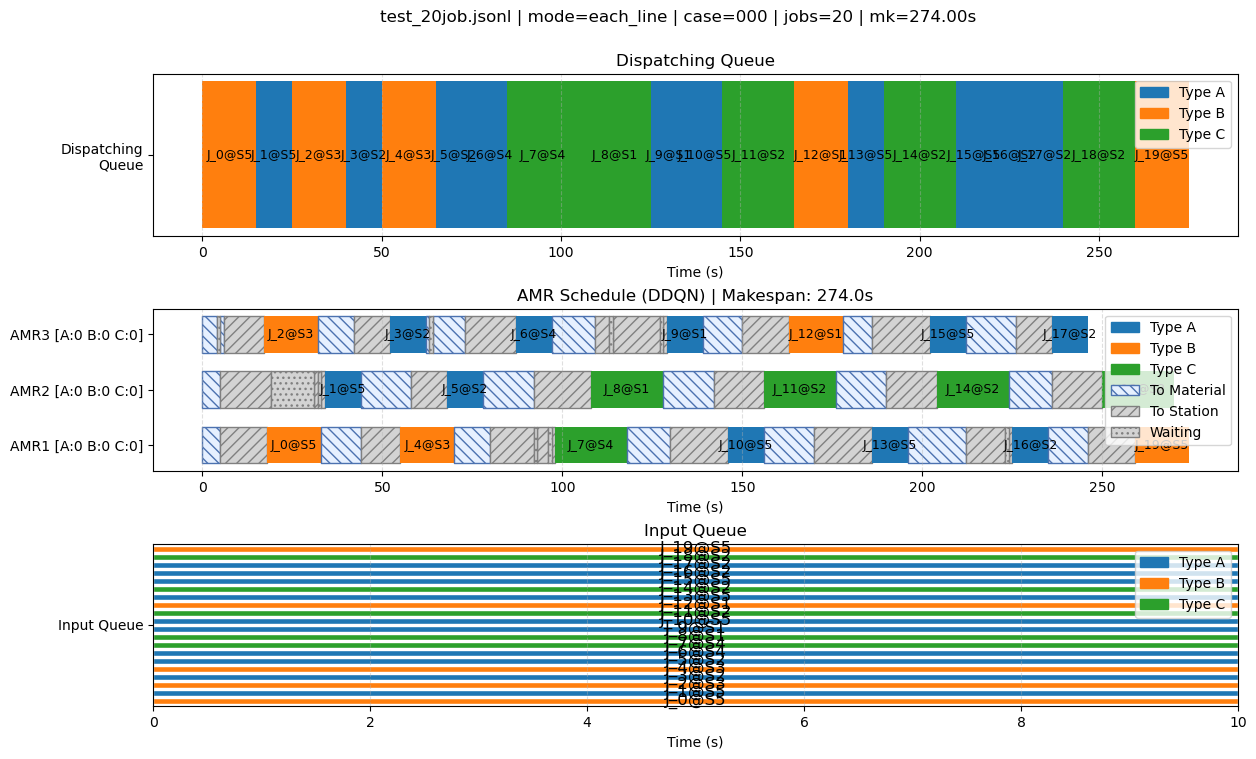

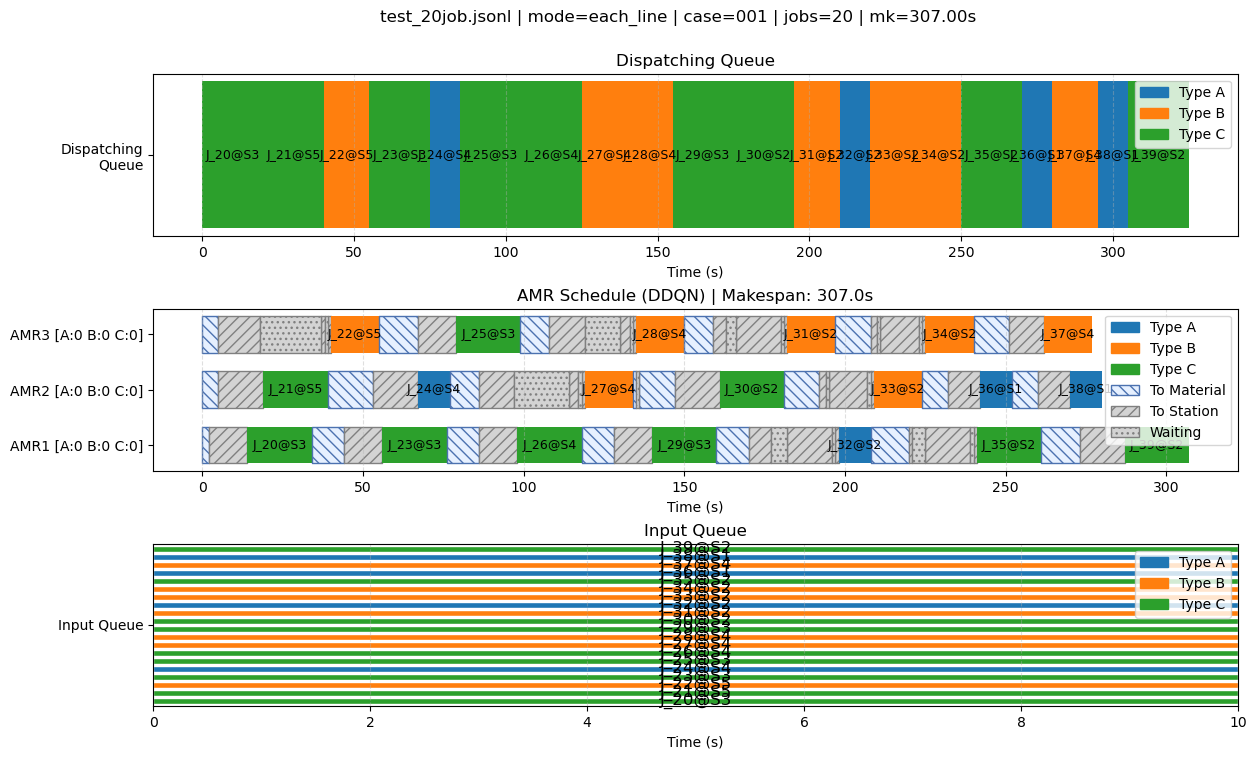

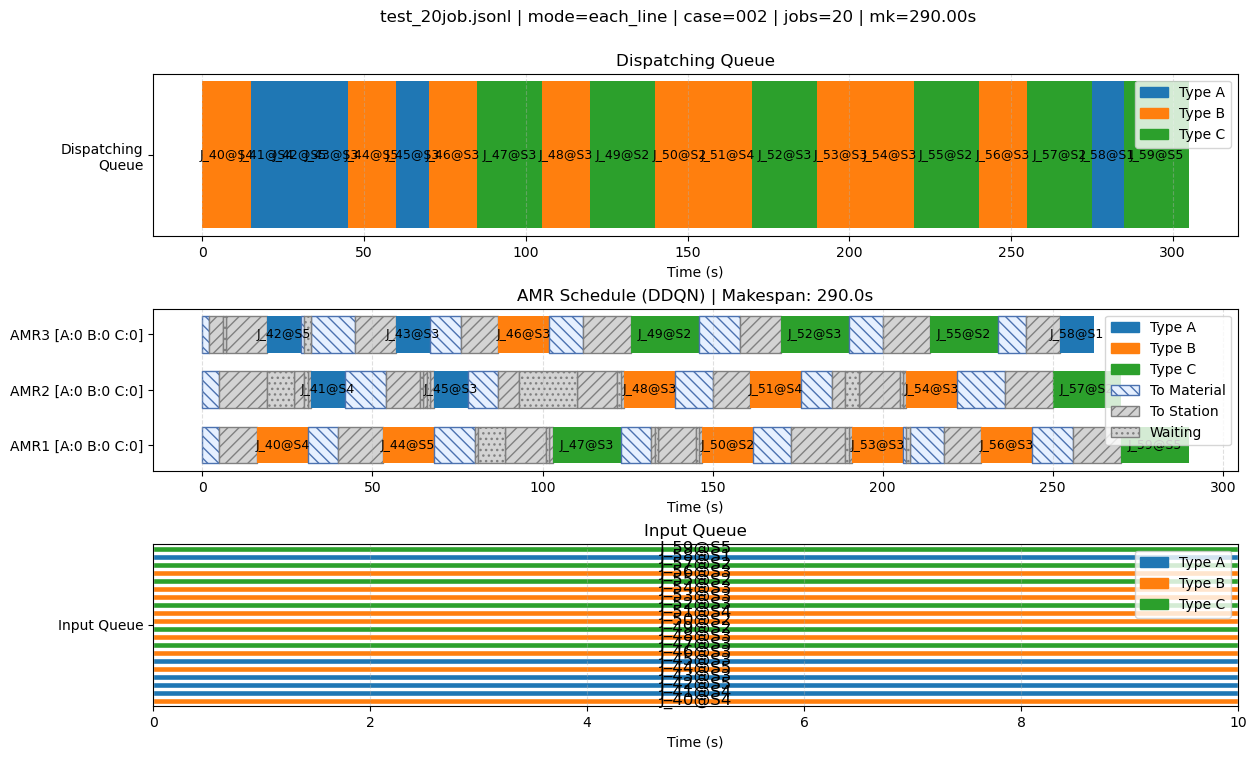

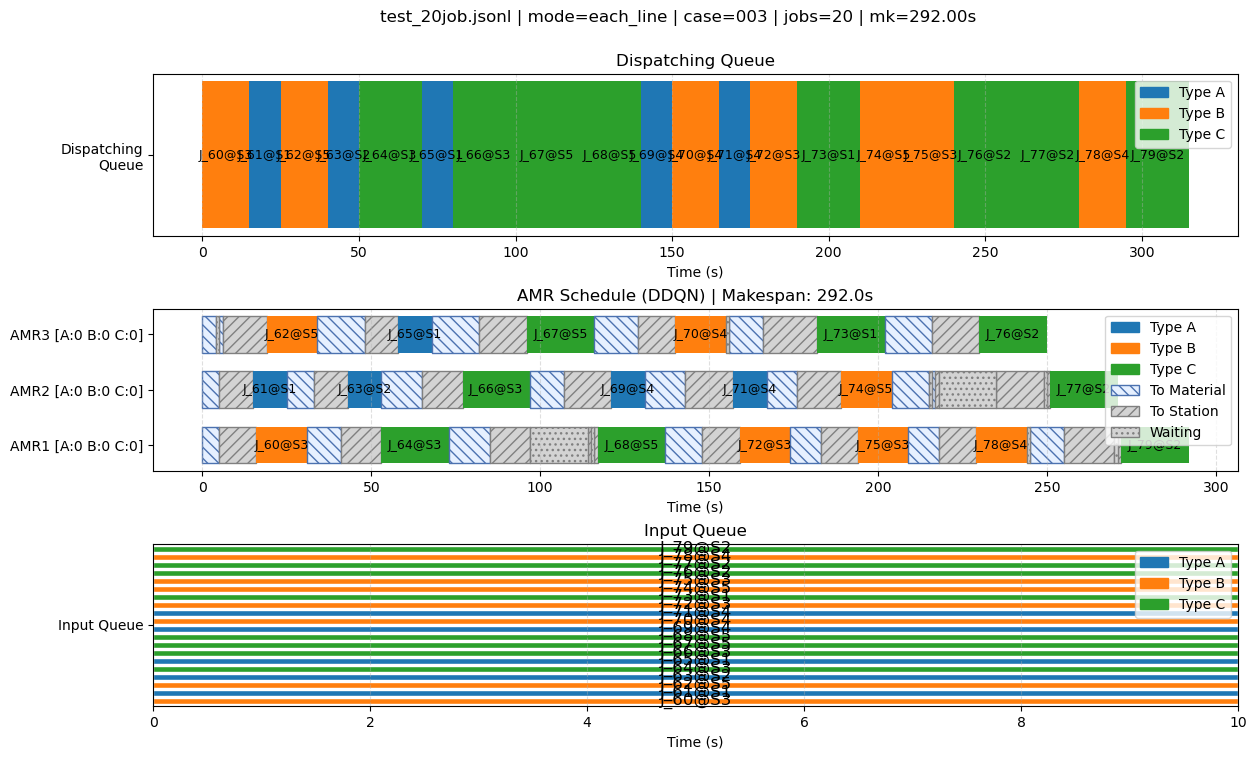

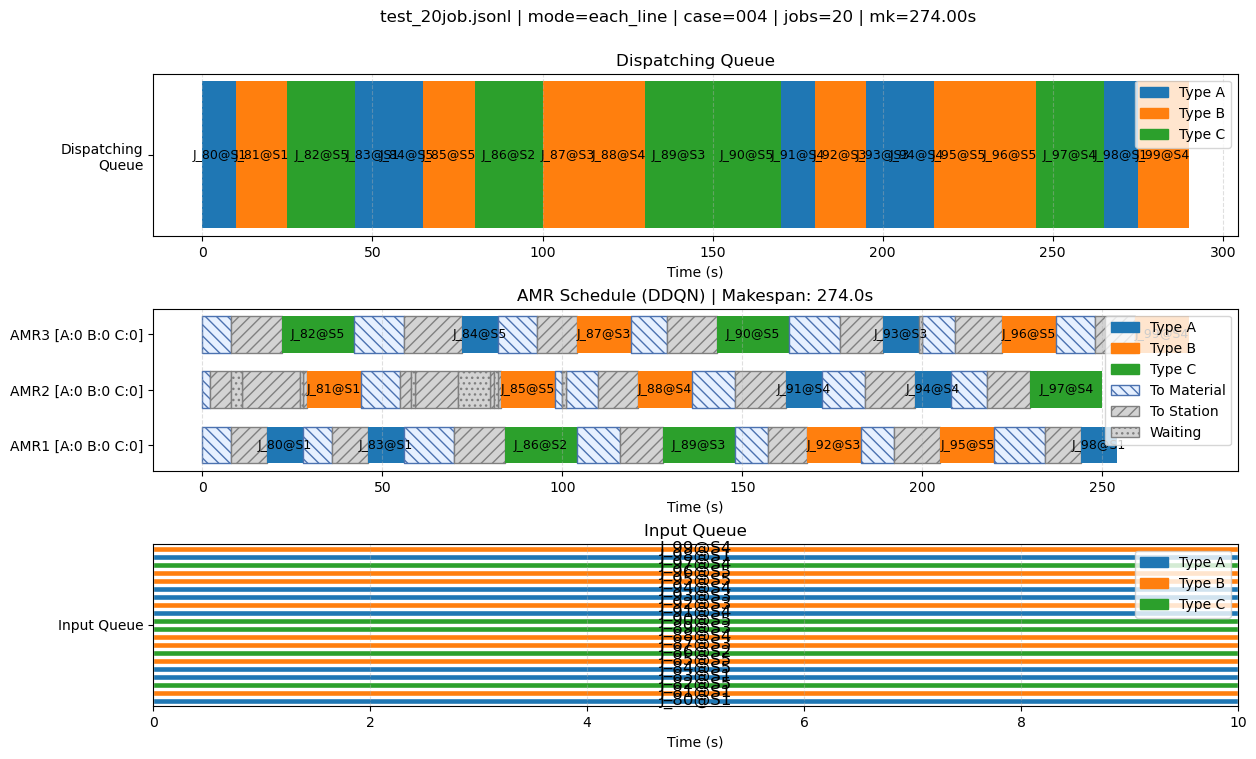

[test_20job.jsonl] CASE 000 jobs=20 mk=274.000 mk/job=13.700 mk/proc=0.996
[test_20job.jsonl] CASE 000 route_jsonl=test_route_logs\test_20job_case_000_amr_path.jsonl lines=275
[test_20job.jsonl] CASE 001 jobs=20 mk=307.000 mk/job=15.350 mk/proc=0.945
[test_20job.jsonl] CASE 001 route_jsonl=test_route_logs\test_20job_case_001_amr_path.jsonl lines=308
[test_20job.jsonl] CASE 002 jobs=20 mk=290.000 mk/job=14.500 mk/proc=0.951
[test_20job.jsonl] CASE 002 route_jsonl=test_route_logs\test_20job_case_002_amr_path.jsonl lines=291
[test_20job.jsonl] CASE 003 jobs=20 mk=292.000 mk/job=14.600 mk/proc=0.927
[test_20job.jsonl] CASE 003 route_jsonl=test_route_logs\test_20job_case_003_amr_path.jsonl lines=293
[test_20job.jsonl] CASE 004 jobs=20 mk=274.000 mk/job=13.700 mk/proc=0.945
[test_20job.jsonl] CASE 004 route_jsonl=test_route_logs\test_20job_case_004_amr_path.jsonl lines=275


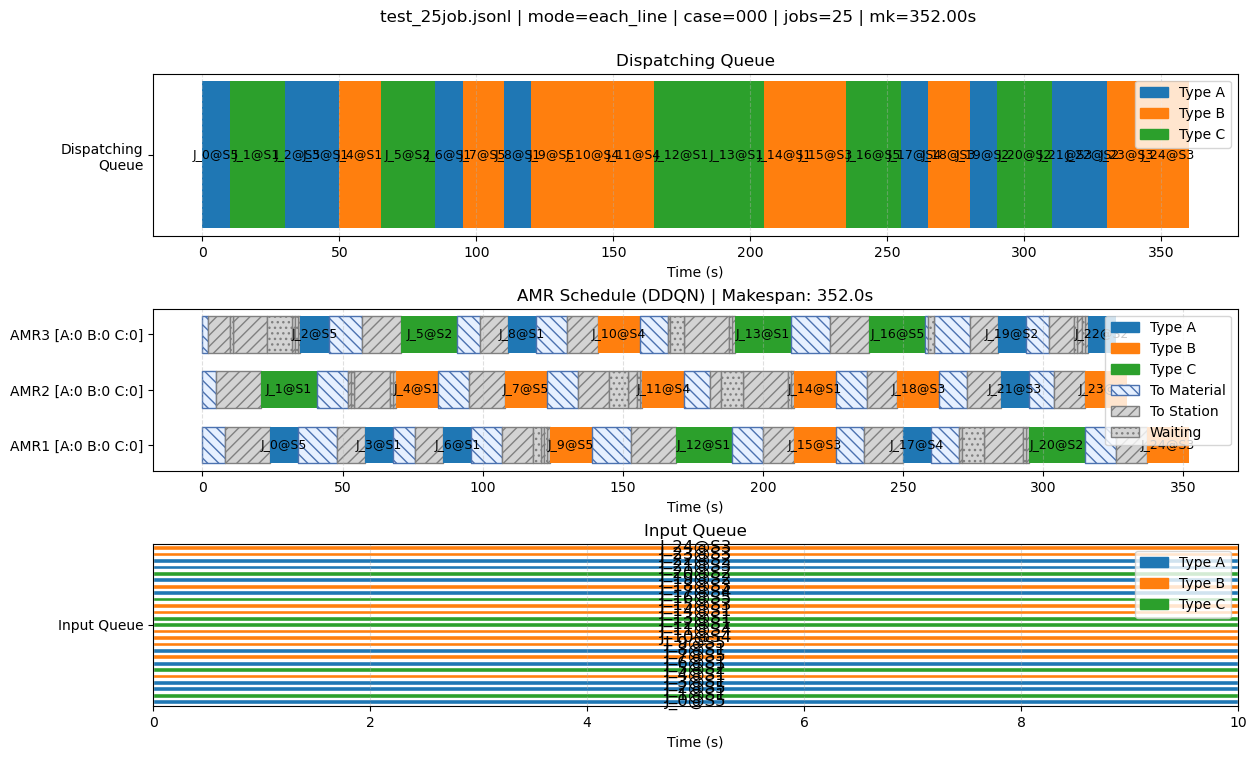

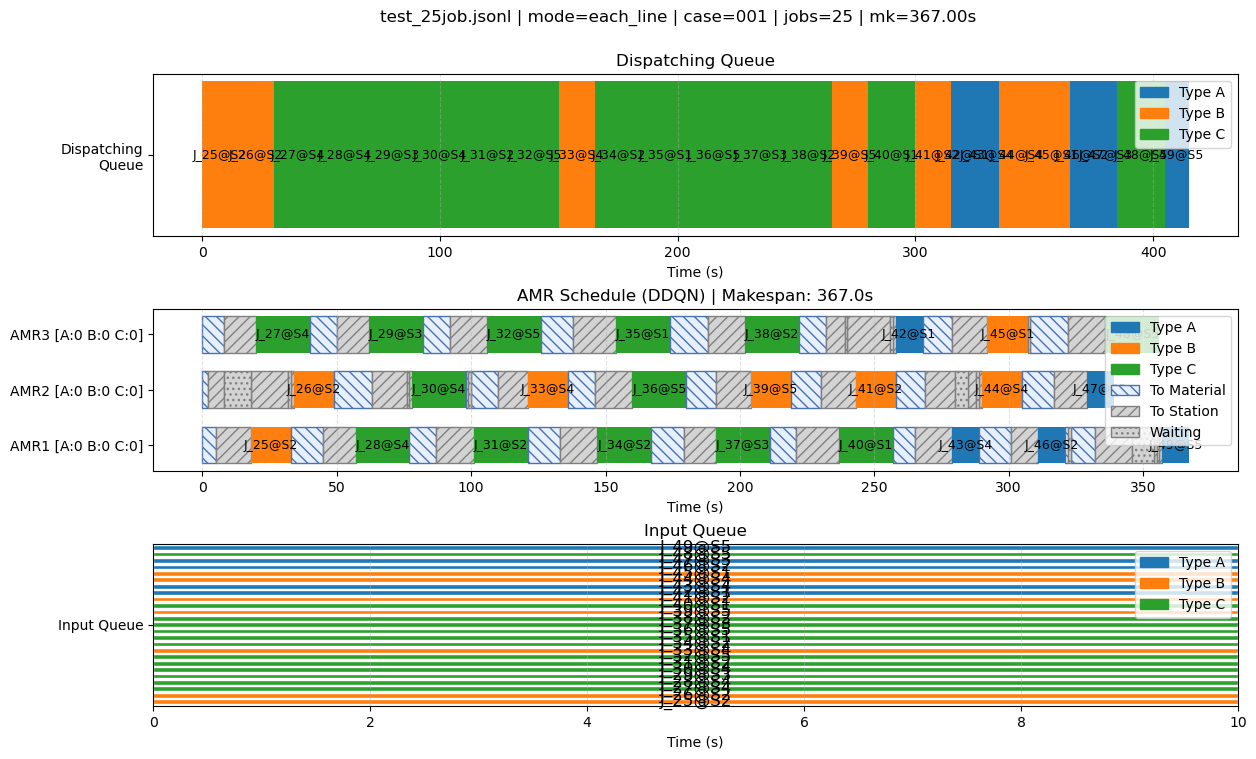

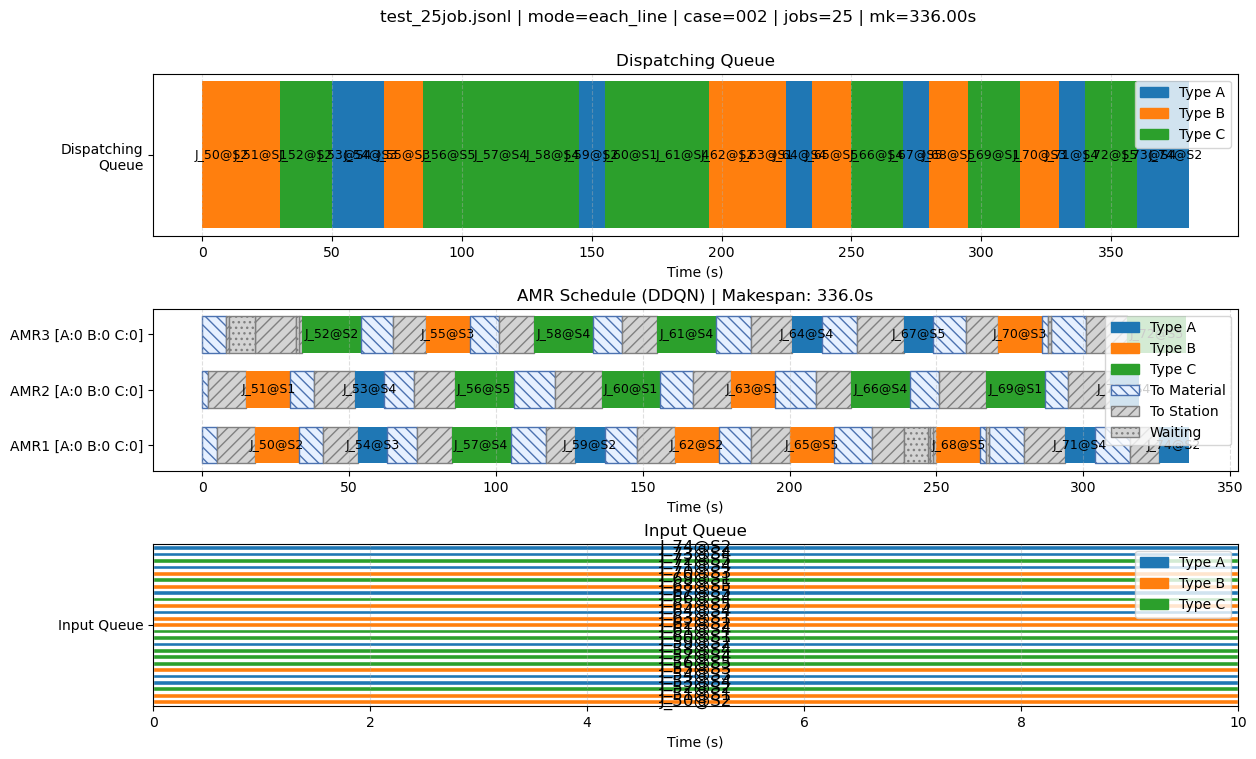

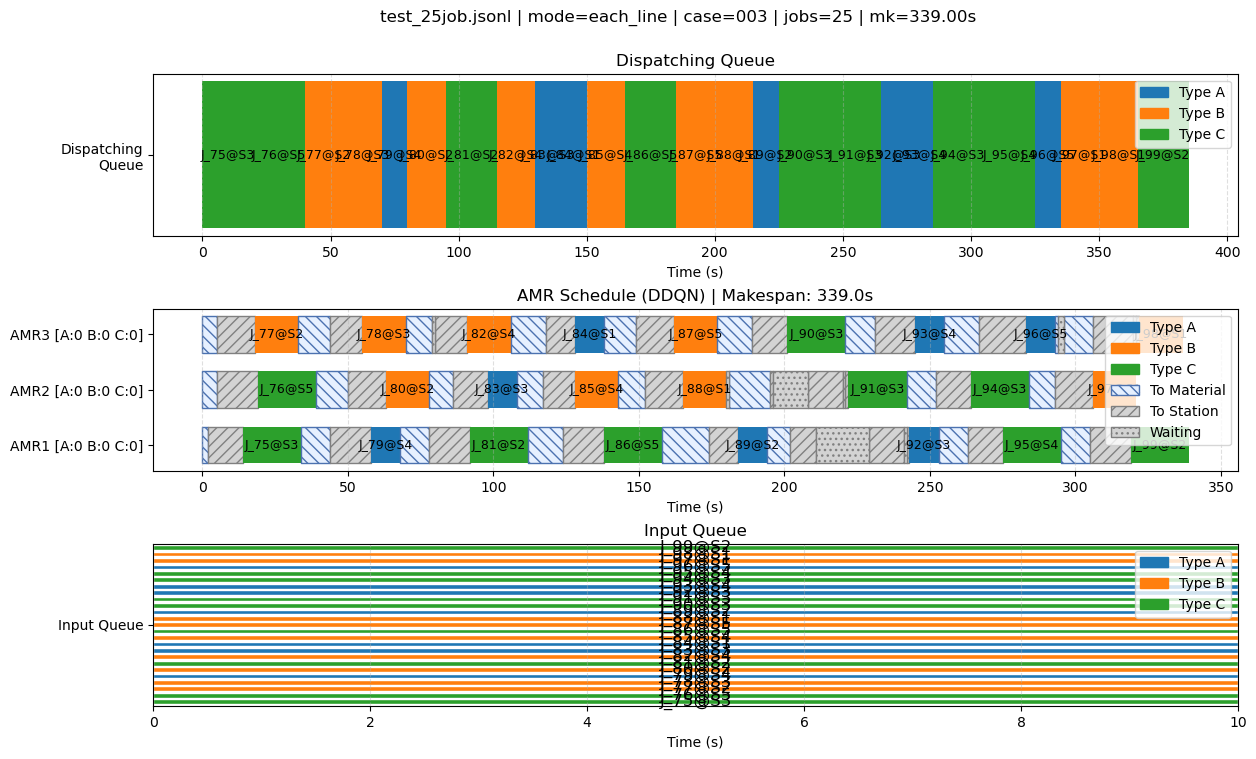

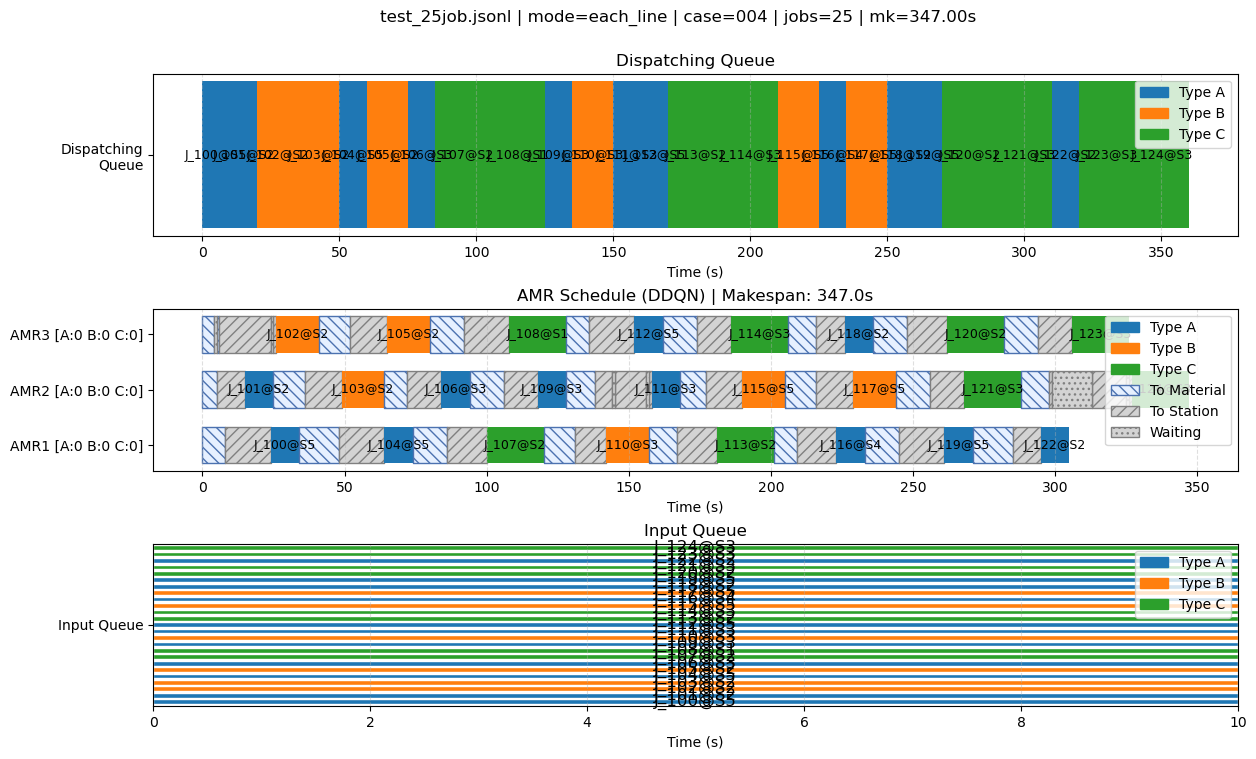

[test_25job.jsonl] CASE 000 jobs=25 mk=352.000 mk/job=14.080 mk/proc=0.978
[test_25job.jsonl] CASE 000 route_jsonl=test_route_logs\test_25job_case_000_amr_path.jsonl lines=353
[test_25job.jsonl] CASE 001 jobs=25 mk=367.000 mk/job=14.680 mk/proc=0.884
[test_25job.jsonl] CASE 001 route_jsonl=test_route_logs\test_25job_case_001_amr_path.jsonl lines=368
[test_25job.jsonl] CASE 002 jobs=25 mk=336.000 mk/job=13.440 mk/proc=0.884
[test_25job.jsonl] CASE 002 route_jsonl=test_route_logs\test_25job_case_002_amr_path.jsonl lines=337
[test_25job.jsonl] CASE 003 jobs=25 mk=339.000 mk/job=13.560 mk/proc=0.881
[test_25job.jsonl] CASE 003 route_jsonl=test_route_logs\test_25job_case_003_amr_path.jsonl lines=340
[test_25job.jsonl] CASE 004 jobs=25 mk=347.000 mk/job=13.880 mk/proc=0.964
[test_25job.jsonl] CASE 004 route_jsonl=test_route_logs\test_25job_case_004_amr_path.jsonl lines=348


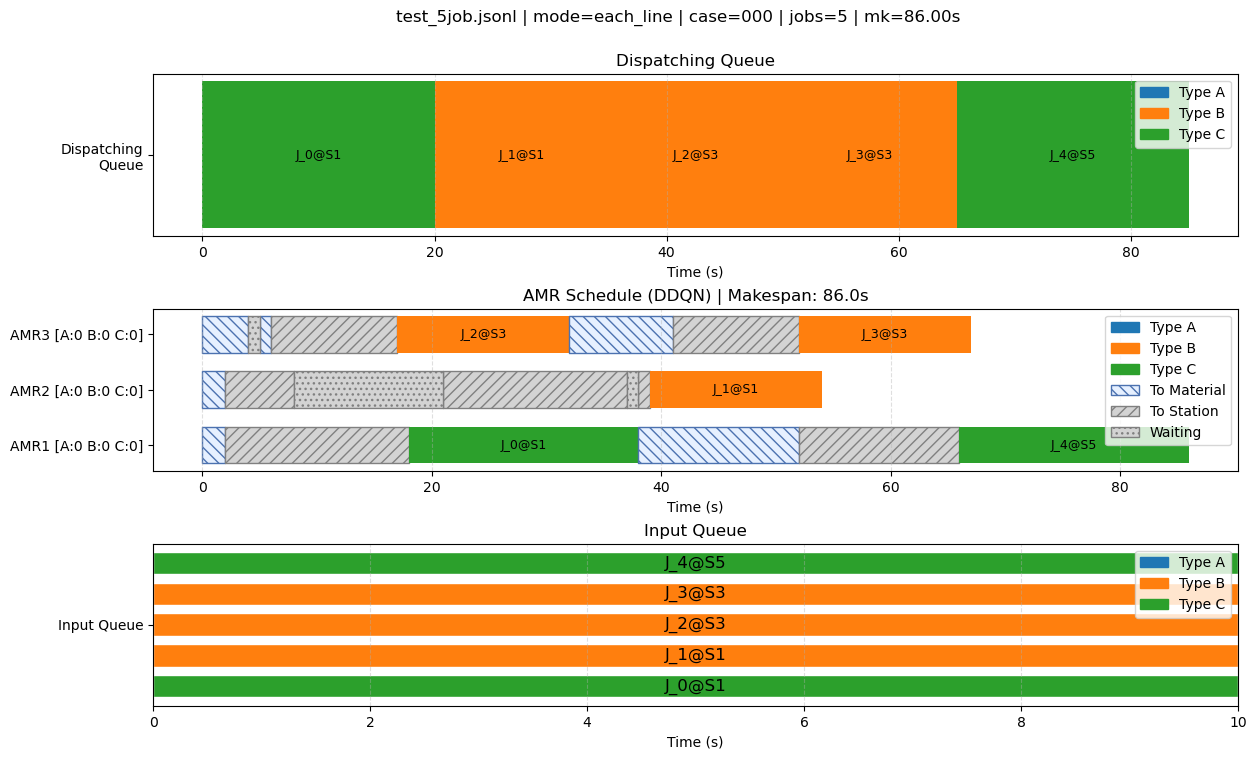

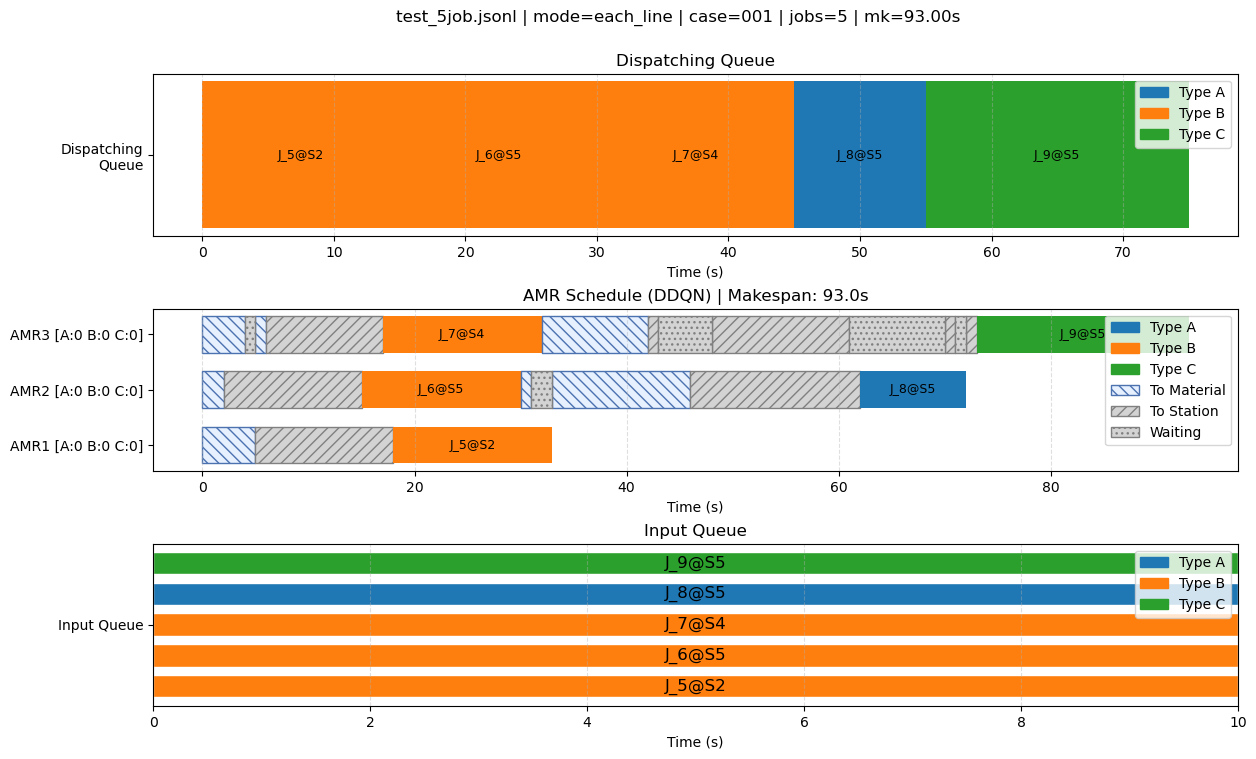

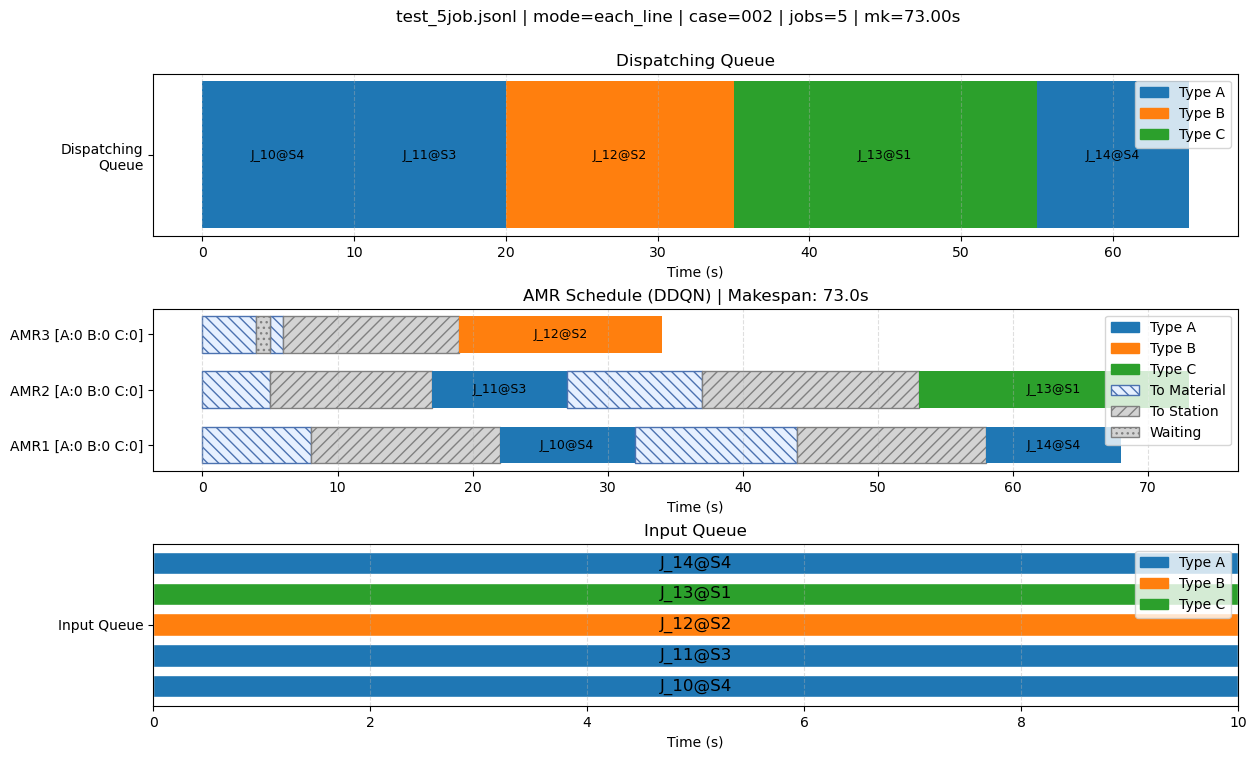

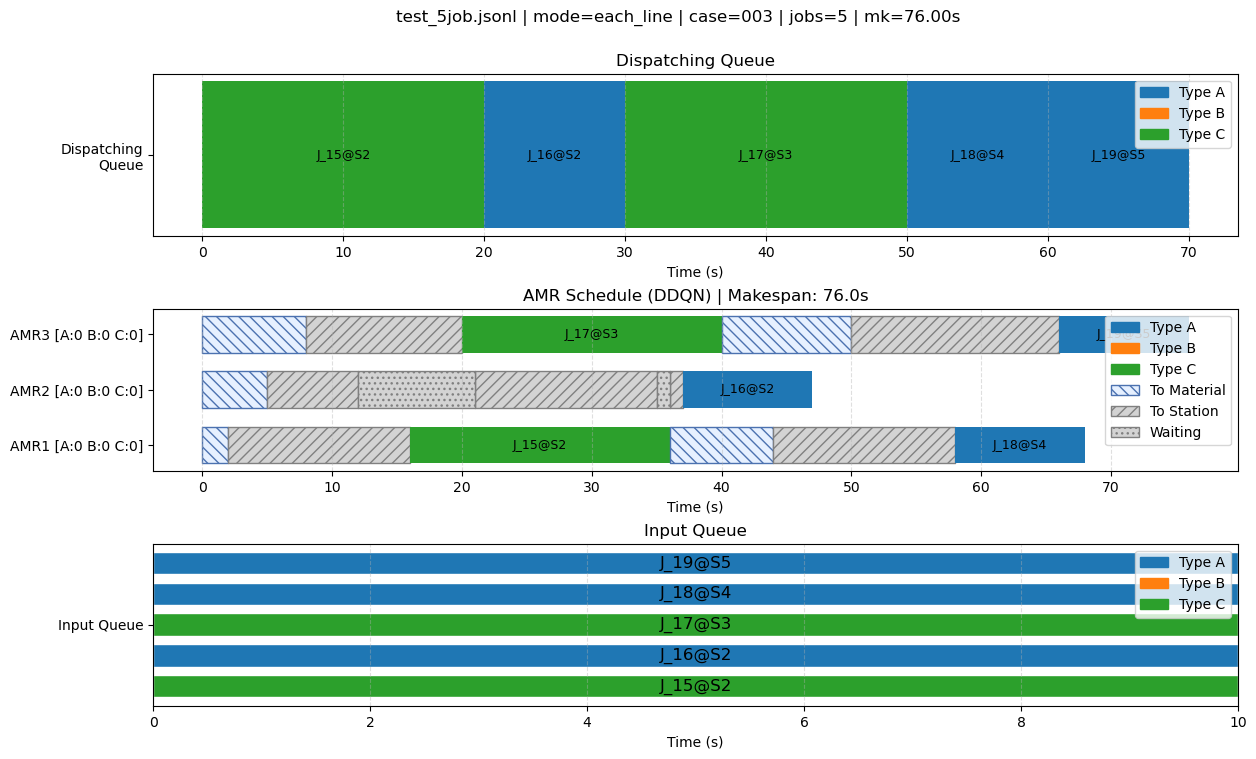

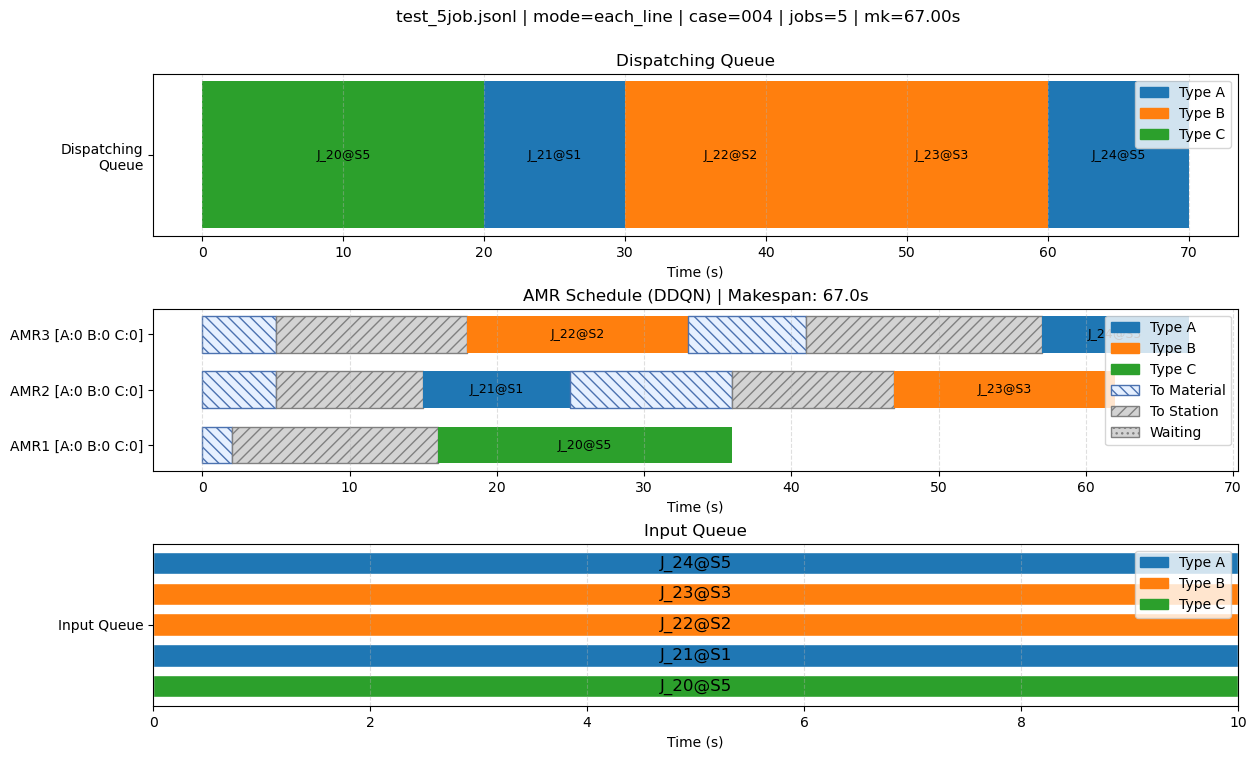

[test_5job.jsonl] CASE 000 jobs=5 mk=86.000 mk/job=17.200 mk/proc=1.012
[test_5job.jsonl] CASE 000 route_jsonl=test_route_logs\test_5job_case_000_amr_path.jsonl lines=87
[test_5job.jsonl] CASE 001 jobs=5 mk=93.000 mk/job=18.600 mk/proc=1.240
[test_5job.jsonl] CASE 001 route_jsonl=test_route_logs\test_5job_case_001_amr_path.jsonl lines=94
[test_5job.jsonl] CASE 002 jobs=5 mk=73.000 mk/job=14.600 mk/proc=1.123
[test_5job.jsonl] CASE 002 route_jsonl=test_route_logs\test_5job_case_002_amr_path.jsonl lines=74
[test_5job.jsonl] CASE 003 jobs=5 mk=76.000 mk/job=15.200 mk/proc=1.086
[test_5job.jsonl] CASE 003 route_jsonl=test_route_logs\test_5job_case_003_amr_path.jsonl lines=77
[test_5job.jsonl] CASE 004 jobs=5 mk=67.000 mk/job=13.400 mk/proc=0.957
[test_5job.jsonl] CASE 004 route_jsonl=test_route_logs\test_5job_case_004_amr_path.jsonl lines=68

====== PER-FILE SUMMARY ======
test_10job.jsonl: cases=5 avg_mk=146.600 min=130.000 max=165.000
test_15job.jsonl: cases=5 avg_mk=213.200 min=197.000 

In [2]:
# Example A: test a single jsonl as one multi-dispatch scenario
# TEST_CFG = {
#     "target_path": "test_case/case_04_train_stream_000.jsonl",
#     "model_path": "ddqn_policy.pt",
#     "case_mode": "full_stream",
# }

# Example B: test a single jsonl line-by-line (each line as one single-dispatch case)
# TEST_CFG = {
#     "target_path": "test_case/case_04_train_stream_000.jsonl",
#     "model_path": "ddqn_policy.pt",
#     "case_mode": "each_line",
# }

# Example C: test all jsonl in test_case folder
TEST_CFG = {
    "target_path": "test_case",
    "model_path": "ddqn_policy_100epoch.pt",
    "case_mode": "each_line",      # "full_stream" | "each_line"
    "max_files": None,                 # e.g. 3
    "max_cases_per_file": None,        # only used when each_line
    "plot": True,
    "save_plots": True,
    "plot_dir": "test_plots",
    "show_route_map": False,
    "show_plotly": False,            # True => generate HTML via viz_plotly.py
    "plotly_html_dir": "test_plots_html",
    "plotly_window": 80.0,
    "plotly_step": 5.0,
    "save_route_jsonl": True,       # True => export per-second AMR route log jsonl
    "route_jsonl_dir": "test_route_logs",
    "route_time_step": 1.0,
    "save_stats_txt": True,         # True => export case + summary stats to txt
    "stats_txt_path": "test_output/test_stats.txt",
    "stats_txt_append": True,
    "allow_proactive_replenish": True,
}

results = run_tests(**TEST_CFG)
print(f"result_rows = {len(results)}")
